## View PSF as a surface plot

In [34]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import math
from math import tan, atan, hypot, log10
from FT_model import model_FT
from fits_to_pupil import generate_pupil
from mpl_toolkits.axes_grid1 import make_axes_locatable
from radial_gradient import RWGE
from power_region import power_ratio
from symmetry import create_symmetry
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm


In [9]:
%%time
indexes = [10, 3, 4, 8, 9]
# indexes = [10]
pupils = []

for i in indexes:
    pupil_name = "ToliBoy_Pupil_Designs/ToliBoy_Pupil_{}.fits".format(i)
    pupil = generate_pupil(fits.open(pupil_name)[0].data)
        
    if i == 4:
        pupil = create_symmetry(pupil, 10)

    pupils.append(pupil)

/Users/louis/Pupil_design/Pupil_simulations/symmetry.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  B[i][j] += A[k][l]/f


CPU times: user 28.1 s, sys: 180 ms, total: 28.3 s
Wall time: 28.6 s


In [10]:
# Basic simuation settings
aperture = 0.018                 # Aperture (m)
npixels = 1024                   # Size of detector, in pixels
wl = 0.525e-6                    # Wavelength values (micrometers)
fl = 0.15                        # Focal length (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)
lam = 525e-9

In [61]:
# Define the radial region to analyse 
num_fringes = 10.5

# Image viewing extent
fringe_extent_im = 25

# Graph viewing extent
fringe_extent_graph = 25

# Horizontal line fringe values
fringe_0 = num_fringes
fringe_1 = 6

In [62]:
# Calculate needed values
c = npixels//2
pixel_radii_0 = fl*tan(fringe_0*lam/aperture)/detector_pitch
pixel_radii_1 = fl*tan(fringe_1*lam/aperture)/detector_pitch
pixel_extent_im = int(fl*tan(2*fringe_extent_im*lam/aperture)/detector_pitch)
pixel_extent_graph = int(fl*tan(2*fringe_extent_graph*lam/aperture)/detector_pitch)
xvals = np.linspace(0, fringe_extent_im, pixel_extent_im//2)
index_0 = int(fringe_0*pixel_extent_graph/(2*fringe_extent_graph))
index_1 = int(fringe_1*pixel_extent_graph/(2*fringe_extent_graph))

In [63]:
%%time
outputs = []
for pupil in pupils:
    
    im_out = model_FT(pupil, aperture, npixels, [wl], fl, detector_pitch)
    im_out = im_out/np.sum(im_out)
        
    gradient = "{:.2f}".format(RWGE(im_out)*1e6)
    gradient_in_0 = "{:.2f}".format(RWGE(im_out, max=pixel_radii_0)*1e6)
    gradient_in_1 = "{:.2f}".format(RWGE(im_out, max=pixel_radii_1)*1e6)
    
    ratio_0 = "{:.2f}".format(power_ratio(im_out, pixel_radii_0)*100)
    ratio_1 = "{:.2f}".format(power_ratio(im_out, pixel_radii_1)*100)
    
    pixel_peak = "{:.2f}".format(np.max(im_out)*1e5)
    central = "{:.2f}".format(im_out[im_out.shape[0]//2][im_out.shape[0]//2]*1e5)
    
    evaluation = [gradient, gradient_in_0, gradient_in_1, ratio_0, ratio_1, pixel_peak, central]

    regions = np.zeros(npixels)
    peaks = np.zeros(npixels)
    cum_sum = np.zeros(npixels)
    
    for j in range(npixels):
        for k in range(npixels):
            x = j - c
            y = k - c
            r = int(hypot(x, y))
            regions[r] += im_out[j][k]
            peaks[r] = im_out[j][k] if im_out[j][k] > peaks[r] else peaks[r]
    
    for j in range(len(regions)):
        cum_sum[j] = regions[j] if j == 0 else cum_sum[j-1] + regions[j]
            
    outputs.append([pupil, im_out, evaluation, regions, peaks, cum_sum])

CPU times: user 41.3 s, sys: 3.15 s, total: 44.5 s
Wall time: 38.2 s


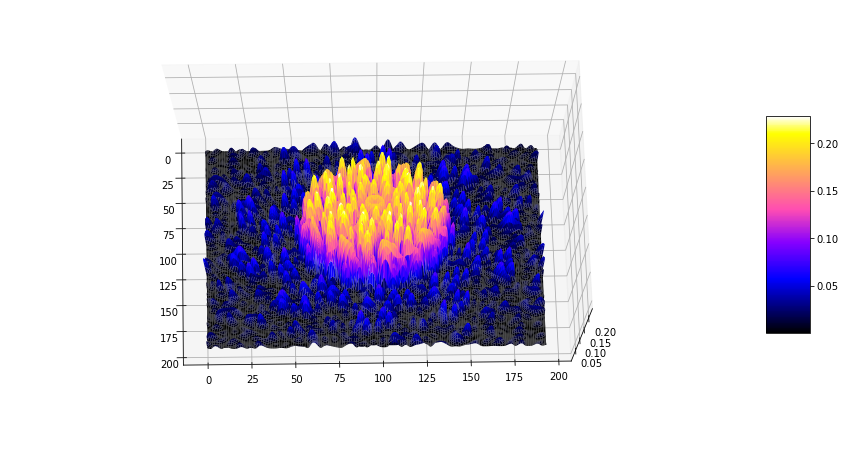

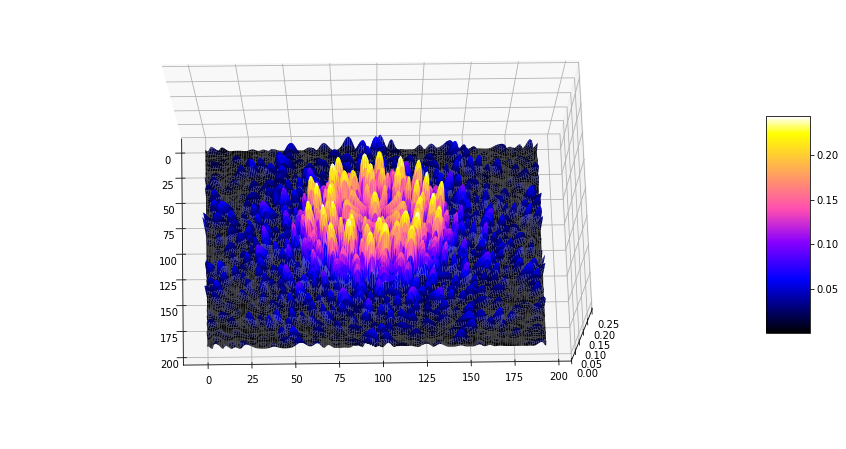

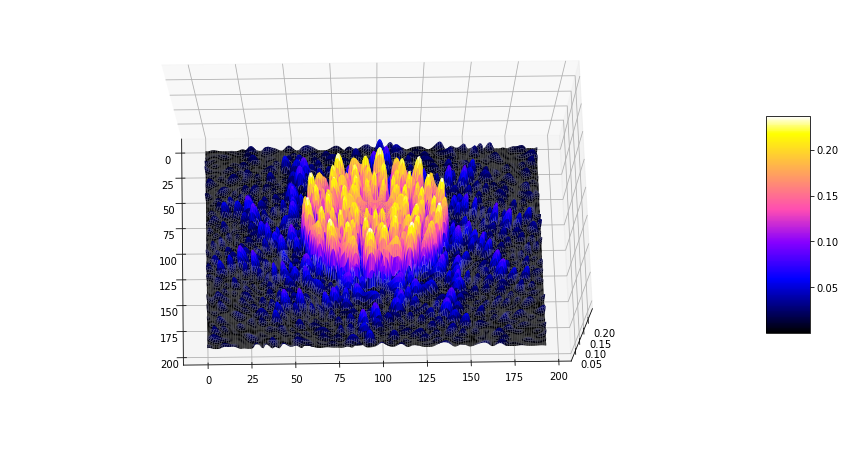

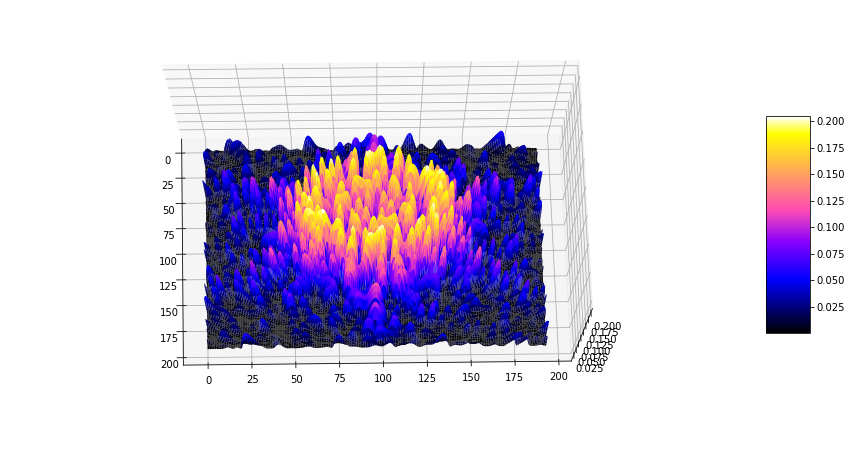

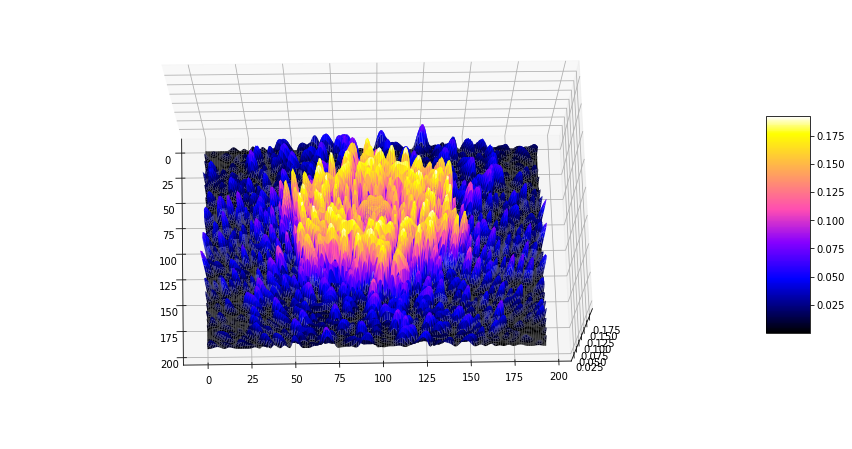

In [66]:
for pupil_file in outputs:
    pupil = pupil_file[0]
    im_out = pupil_file[1]
    evaluation = pupil_file[2]
    regions = pupil_file[3]
    peaks = pupil_file[4]
    cum_sum = pupil_file[5]

    # Load PSF
    lena = im_out[int(c-pixel_extent_im//2):int(c+pixel_extent_im//2),int(c-pixel_extent_im//2):int(c+pixel_extent_im//2)]*1e5

    # create the x and y coordinate arrays (here we just use pixel indices)
    xx, yy = np.mgrid[0:lena.shape[0], 0:lena.shape[1]]

    # create the figure
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca(projection='3d')
#     ax.set_zlim3d(-1,2)
    surf = ax.plot_surface(xx, yy, (lena+1)**0.05 -1 ,rstride=1, cstride=1, cmap=cm.gnuplot2, linewidth=0)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    for ii in range(0,360,1):
        ax.view_init(elev=75., azim=ii)

    # show it
    plt.show()

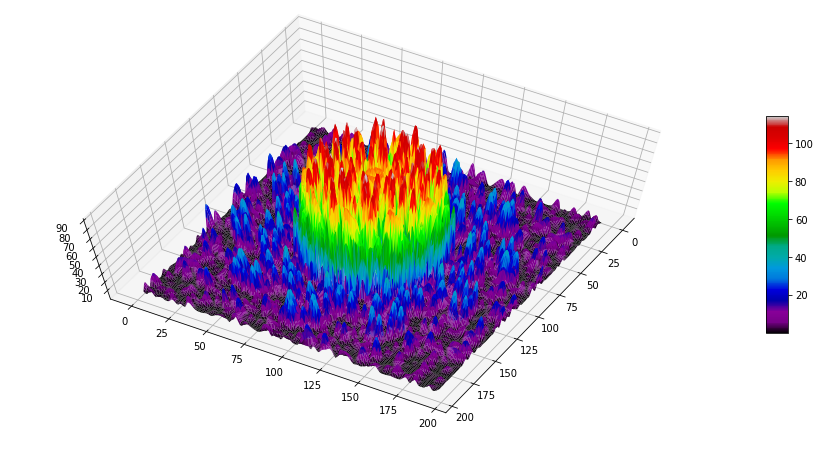

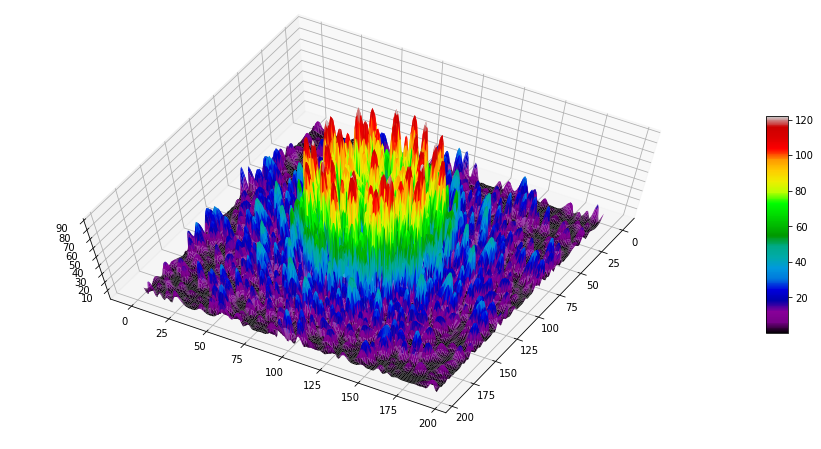

KeyboardInterrupt: 

In [80]:
for pupil_file in outputs:
    pupil = pupil_file[0]
    im_out = pupil_file[1]
    evaluation = pupil_file[2]
    regions = pupil_file[3]
    peaks = pupil_file[4]
    cum_sum = pupil_file[5]

    # Load PSF
    plot_3d = im_out[int(c-pixel_extent_im//2):int(c+pixel_extent_im//2),int(c-pixel_extent_im//2):int(c+pixel_extent_im//2)]1e5
    plot_3d = ((plot_3d + 1)**0.05 - 1)*500
    xx, yy = np.mgrid[0:plot_3d.shape[0], 0:plot_3d.shape[1]]

    fig = plt.figure(figsize=(16,8))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xx, yy, plot_3d ,rstride=1, cstride=1, cmap=cm.nipy_spectral, linewidth=0)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax.view_init(elev=70., azim=30)
    ax.set_zlim3d(1,90)

    plt.show()